# Lecture 13 FITS Images and tables

### Review - Previous lecture 



FITS files are the most commonly used data format in astronomy

A FITS file consists of one or more sets of data divided into Header Data Units (HDUs)

Each HDU consists of 
- Header - Contains information about the data and relavant info about how the data was aquired (what telescope, the exposure, etc.)
- Data - The data itself, either in the form of a table (row and columns) or an image (just a 2D array)

We can use the `fits` module from astropy to read data in FITS files

>from astropy.io import fits
>
>fits_file_name = 'data.fits'
>
>HDU_list = fits.open(fits_file_name)

### New Stuff for Today

Astronomical Images

Telescopes and Cameras are typically made up of focusing optics (mirrors, lenses, etc.) and an array of detectors

The focusing optics direct photons coming from a specific direction onto a specific detector (pixel)

When a picture is taken the array of detectors count the number of photons they each detect. 

The number of photons are then read out, resulting in a 2D positional array of photon counts 

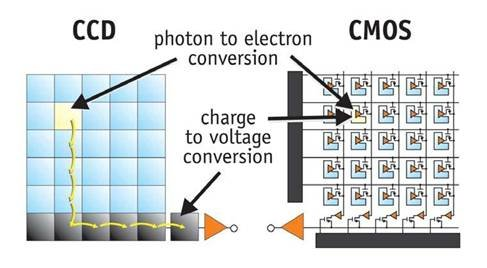

The detecting arrays in cameras like the ones on your phones and the ones used in telescopes are actually similar.

A major difference though is the output 

Your phone camera uses color filters to create a red, green, and blue image and outputs a color image 
- Like 2 lectures ago, an image file contains the colors, not the number of photons

The output from a telescope will be a single image at a time with the number of photons in each pixel

Let's look at some real data 

Let's look at an image taken by the Sloan Digital Sky Survey

In [2]:
from astropy.io import fits

# Long weird url, it will just download an image from a database
f = fits.open('https://cdsarc.cds.unistra.fr/saadavizier/download?oid=864972989978903253')
# Let's see what's in the file
f.info()

Filename: /home/jimmy/.astropy/cache/download/url/59d9273e23881b42f159c6f2de02b1e9/contents
No.    Name      Ver    Type      Cards   Dimensions   Format
  0  PRIMARY       1 PrimaryHDU      65   (1307, 1307)   float32   


Let's check out the header

In [ ]:
f[0].header

SIMPLE  =                    T / Written by IDL:  Wed Oct 15 12:49:38 2014      
BITPIX  =                  -32 /                                                
NAXIS   =                    2 /                                                
NAXIS1  =                 1307 / NUMBER OF ELEMENTS ALONG THIS AXIS             
NAXIS2  =                 1307 / NUMBER OF ELEMENTS ALONG THIS AXIS             
EXTEND  =                    T / This file may contain FITS extensions          
EQUINOX =        2000.00000000 / Mean equinox                                   
RADECSYS= 'ICRS    '           / Astrometric system                             
CTYPE1  = 'RA---TAN'           / WCS projection type for this axis              
CUNIT1  = 'deg     '           / Axis unit                                      
CRVAL1  =   1.826360000000E+02 / World coordinate on this axis                  
CRPIX1  =   6.540000000000E+02 / Reference pixel on this axis                   
CD1_1   =  -1.099999994040E-

Let's get the data

In [4]:
image_data = f[0].data
# What type is the data? 
print(type(image_data))

<class 'numpy.ndarray'>


In [ ]:
# What's the shape?
print(image_data.shape)

(1307, 1307)


Let's plot it to see what the image looks like

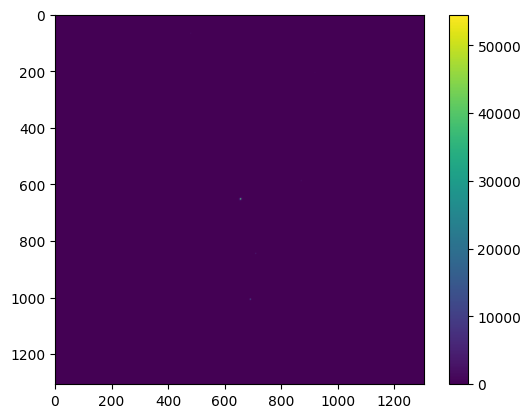

In [5]:
import matplotlib.pyplot as plt
plt.imshow(image_data)
plt.colorbar()

Doesn't look like much, let's do some investigating 

In [ ]:
import numpy as np
# There are some "bad" pixels, that are NaN's
# Using nanmean or nanmax, etc. ignores the NaNs
np.nanmean(f[0].data), np.nanmin(f[0].data), np.nanmax(f[0].data)

(np.float32(1.926362), np.float32(-21.502079), np.float32(54545.91))

What's going on here?

- Why is there such a large range?
- Why are there negative values?
- Why are they not integers?

In [46]:
print('number of pixels above 10,000 =',np.sum(image_data > 1e4))
print('number of pixels above 1,000 =',np.sum(image_data > 1e3))
print("total pixels =", image_data.size)

number of pixels above 10,000 = 35
number of pixels above 1,000 = 190
total pixels = 1708249


In [ ]:
plt.imshow(image_data, vmin=1, vmax=100)
plt.colorbar()

In [ ]:
import matplotlib.pyplot as plt
from matplotlib.colors import LogNorm
from matplotlib import cm

plt.imshow(f[0].data, norm=LogNorm(vmin=1, vmax=5e2))#, cmap=cm.magma)
plt.colorbar()

In [ ]:
import matplotlib.pyplot as plt
from matplotlib.colors import LogNorm
from matplotlib import cm

plt.imshow(f[0].data, norm=LogNorm(vmin=1, vmax=5e2), cmap=cm.cubehelix)
plt.colorbar()

This looks cool, but what and where are we looking at

Let's go back to our header

In [ ]:
f[0].header

In [ ]:
# what object were they pointing at
print(f[0].header['OBJECT'])

What is that?

Let's see by going here 

https://simbad.cds.unistra.fr/simbad/sim-id?Ident=NGC+4151&NbIdent=1&Radius=2&Radius.unit=arcmin&submit=submit+id

Let's try to find the sky position of what we're looking at

In [ ]:
print(f[0].header['CTYPE1'], f[0].header['CTYPE2'])
print(f[0].header['CRVAL1'], f[0].header['CRVAL2'])

In [ ]:
print(f[0].header['CRPIX1'], f[0].header['CRPIX2'])

In [ ]:
crpix1 = int(f[0].header['CRPIX1'])
crpix2 = int(f[0].header['CRPIX2'])
print(image_data[crpix1, crpix2])

So now we know the position of 1 pixel, what about the others

Looks like some type of transformation, using some linear algebra or black magic (same difference)

The WCS projection is a standard format to describe how to convert from pixel position to sky coordinates

Most images will have this specific format of information in their headers 

Luckily there's existing modules that will do this transfomation for us!

In [8]:
from astropy.wcs import WCS

to initiate a WCS object, you just pass it the header

In [9]:
wcs = WCS(f[0].header)

the RADECSYS keyword is deprecated, use RADESYSa. [astropy.wcs.wcs]


In [ ]:
# Get back out the WCS format
wcs.printwcs()

The wcs object has 2 main functions

- `world_to_pixel_values()` - transforms sky coordinates (here RA, Dec) to pixel position

- `pixel_to_world_values()` - transforms from pixel position (array indexes) to sky coordinates

In [ ]:
wcs.world_to_pixel_values(182.636, 39.4059)

In [19]:
ras = np.linspace(-0.01, 0.01, 5) + 182.636
decs = np.linspace(-0.01, 0.01, 5) + 39.4059

In [20]:
xpix, ypix = wcs.world_to_pixel_values(ras, decs)
print(xpix)
print(ypix)

[723.25263736 688.1238005  653.         617.88123565 582.76750723]
[562.09479868 607.54642697 653.         698.45551867 743.91298386]


notice, these are not integers

In [ ]:
image_data[xpix,ypix]

In [ ]:
# Let's convert them to ints
image_data[xpix.astype(int),ypix.astype(int)]

Similarly you can do wcs.pixel_to_world() and it will give you an astropy `SkyCoord`

An object designed to store sky coordinates 

In [ ]:
sky_coord = wcs.pixel_to_world(653, 653)
print(sky_coord)

In [ ]:
print(sky_coord.ra)
print(sky_coord.dec)

In [ ]:
print(sky_coord.ra.deg)
print(sky_coord.dec.deg)

Feel free to use SkyCoords or not

You can find out more about them here https://docs.astropy.org/en/stable/api/astropy.coordinates.SkyCoord.html

### Exercise

Find the sky coordinates of the pixel with the largest value

First find the index with the max value

`np.argmax(array)` can be used to find this, but for a 2D array it flattens it to 1D first (annoyingly)
    
to get the 2D indexes you'll have to use a second function, `np.unravel_index(1D_index, shape)`

Next convert the pixel coordinates to ra, dec

The other main use of the WCS module, is transforming plot axes

First initialize a plot axis

This can take a certain projection

In [ ]:
ax = plt.subplot(projection = wcs)

plt.imshow(image_data, vmin=1, vmax=100)
plt.colorbar()

In [ ]:
ax = plt.subplot(projection = wcs)

plt.imshow(image_data, vmin=1, vmax=100)
plt.colorbar()
plt.grid(True)

You can do contours too! Though this is not a great image for contours 

In [ ]:
ax = plt.subplot(projection = wcs)

# plt.imshow(image_data)
plt.contour(image_data, [1e3])
# plt.colorbar()
plt.grid(True)

What's the other stuff in the image?

In [ ]:
plt.imshow(image_data, vmax=100)

Mostly stars, let's try zooming in on one

In [ ]:
plt.imshow(image_data, vmax=100)
plt.xlim(450,500)
plt.ylim(100,40)

Why is it so wide?

In [ ]:
from matplotlib.colors import LogNorm
plt.imshow(image_data, norm=LogNorm(vmax=1e3, vmin=1e1))
plt.xlim(450,500)
plt.ylim(100,40)
plt.colorbar()

This is due what's called the point spread function (PSF)

Telescopes don't have infinite accuracy, due to mulitple reasons the photons from a single direction will get spread out

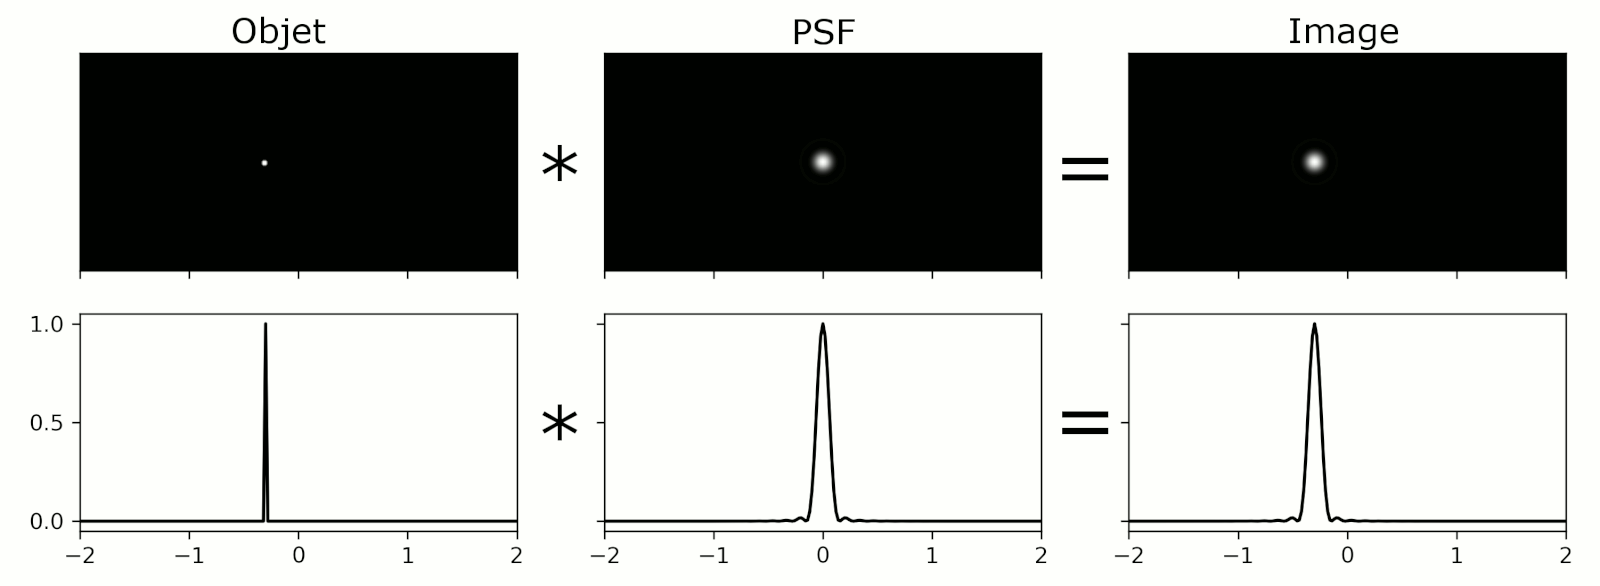

Correcting for the PSF to find the true flux from an image is known as photometry